In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import zipfile
import os
from pathlib import Path
import re
import tensorflow as tf
from tensorflow import keras
from keras import layers

# Setup

In [2]:
# create a path to the pokemon image directory
data_directory = os.path.join(os.getcwd(), 'data')
images_directory = os.path.join(data_directory, 'images/low-res')
images_path = Path(images_directory)
# create a dataframe with the name and filepath of each pokemon
files = list(images_path.glob('*.png')) # get the path of each file
names = [os.path.split(x)[1] for x in list(images_path.glob('*.png'))] # get the name of each file
image_df = pd.concat([pd.Series(names, name='Name'), pd.Series(files, name='Filepath').astype(str)], axis=1) # create a dataframe with the name and filepath of each pokemon
image_df['Name'] = image_df['Name'].str.replace('.png', '') # delete .png extension from name
# load in csv with the name, primary type, and secondary type of each pokemon
csv_directory = os.path.join(data_directory, 'pokemon.csv')
label_df = pd.read_csv(csv_directory)
# merge image_df with label_df
df = image_df.merge(label_df, on='Name')
df.head()


,Name,Filepath,Type1,Type2
0,parasect,/Users/judith/code-projects/pokemastery-projec...,Bug,Grass
1,lumineon,/Users/judith/code-projects/pokemastery-projec...,Water,NaN
2,raikou,/Users/judith/code-projects/pokemastery-projec...,Electric,NaN
3,dedenne,/Users/judith/code-projects/pokemastery-projec...,Electric,Fairy
4,pyroar,/Users/judith/code-projects/pokemastery-projec...,Fire,Normal


In [3]:
# limit data to Fire and Water types
df = df.query("Type1 == 'Fire' | Type1 == 'Water'")
df.head()

,Name,Filepath,Type1,Type2
1,lumineon,/Users/judith/code-projects/pokemastery-projec...,Water,NaN
4,pyroar,/Users/judith/code-projects/pokemastery-projec...,Fire,Normal
6,magmortar,/Users/judith/code-projects/pokemastery-projec...,Fire,NaN
12,charizard,/Users/judith/code-projects/pokemastery-projec...,Fire,Flying
13,infernape,/Users/judith/code-projects/pokemastery-projec...,Fire,Fighting


In [4]:
print("Number of water-types:", len(df[df['Type1'] == 'Water']))
print("Number of fire-types:", len(df[df['Type1'] == 'Fire']))

Number of water-types: 105
Number of fire-types: 47


In [5]:

# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

train_gen = keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,   # split the dataset into a training set and a validation set in an 8:2 ratio
    rescale=1./255          # rescale the rgb values to fit between 0 and 1 
)
train_gen 

In [6]:
train_data = train_gen.flow_from_dataframe(
    df,
    x_col='Filepath',
    y_col='Type1',
    target_size=(120, 120),
    color_mode='rgba',
    class_mode='sparse',
    batch_size=32,
    seed=1,
    subset='training'
)
train_data

Found 122 validated image filenames belonging to 2 classes.


In [7]:
val_data = train_gen.flow_from_dataframe(
    df,
    x_col='Filepath',
    y_col='Type1',
    target_size=(120, 120),
    color_mode='rgba',
    class_mode='sparse',
    batch_size=32,
    seed=1,
    subset='validation'
)
val_data

Found 30 validated image filenames belonging to 2 classes.


In [8]:
img_input = layers.Input(shape=(120, 120, 4))

x = layers.Conv2D(filters=64, kernel_size=(8, 8), activation='relu')(img_input)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(filters=128, kernel_size=(8, 8), activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(filters=256, kernel_size=(8, 8), activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)

output = layers.Dense(units=1, activation='sigmoid')(x)

model = keras.Model(inputs=img_input, outputs=output)

model.compile(
    optimizer='adam',                 
    loss='binary_crossentropy',
    metrics=['acc', keras.metrics.AUC()]
)

# print model layers
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 4)]     0         
                                                                 
 conv2d (Conv2D)             (None, 113, 113, 64)      16448     
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 49, 49, 128)       524416    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 256)       209740

In [9]:
history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=32,
    epochs=100,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/100
4/4 [==============================] - 6s 2s/step - loss: 2.0147 - acc: 0.4590 - auc: 0.5202 - val_loss: 0.6493 - val_acc: 0.7333 - val_auc: 0.4489 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 6s 2s/step - loss: 0.6518 - acc: 0.6803 - auc: 0.4291 - val_loss: 0.5714 - val_acc: 0.7333 - val_auc: 0.8381 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 6s 2s/step - loss: 0.6468 - acc: 0.6803 - auc: 0.5823 - val_loss: 0.6110 - val_acc: 0.7333 - val_auc: 0.9091 - lr: 0.0010
Epoch 4/100
4/4 [==============================] - 6s 2s/step - loss: 0.6500 - acc: 0.6803 - auc: 0.6982 - val_loss: 0.6355 - val_acc: 0.7333 - val_auc: 0.8608 - lr: 0.0010
Epoch 5/100
4/4 [==============================] - 6s 2s/step - loss: 0.6077 - acc: 0.6803 - auc: 0.6461 - val_loss: 0.4824 - val_acc: 0.7333 - val_auc: 0.9290 - lr: 0.0010
Epoch 6/100
4/4 [==============================] - 6s 2s/step - loss: 0.5276 - acc: 0.6803 - auc: 0.8789 - val_loss: 0.4693 - val_acc: 

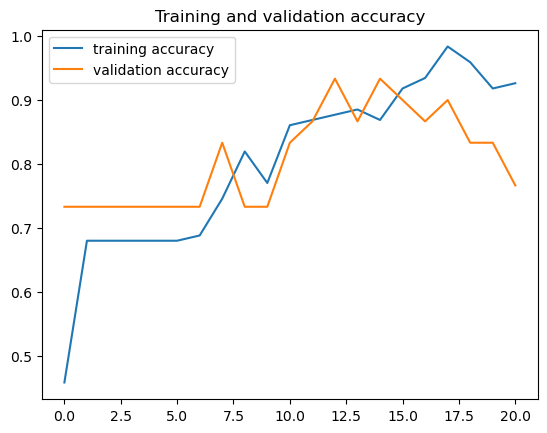

In [15]:

# retrieve accuracy history on training and validation data
acc = history.history['acc']
val_acc = history.history['val_acc']

# retrieve loss history on training and validation data
loss = history.history['loss']
val_loss = history.history['val_loss']

# get number of epochs
epochs = range(len(acc))

# plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

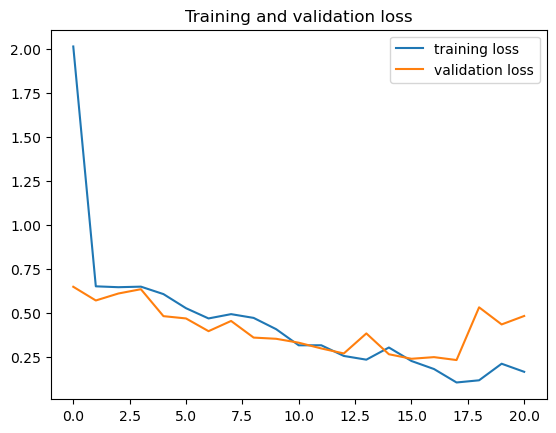

In [16]:
# plot training and validation loss per epoch
plt.figure()
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.title('Training and validation loss')
plt.legend()

In [17]:
# get true labels
true_labels = val_data.labels

# get predictions in the form of probablities 
predictions = model.predict(val_data)
predictions

# convert probablities into binary values 
predictions = [1 if n >= 0.5 else 0 for n in predictions]
print("Model predictions: "+str(predictions))
print("Actual labels:     "+str(true_labels))

1/1 [==============================] - 0s 408ms/step
Model predictions: [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0]
Actual labels:     [1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


In [18]:
# determine filepaths of misclassified pokemon
num_misclasssified = 0
misclassified_filepaths = []
correctness = []
for pred, label, i in zip(predictions, true_labels, range(len(predictions))):
  misclassified_filepaths.append(val_data.filepaths[i])
  if pred != label:
    correctness.append('incorrect')
    num_misclasssified += 1
  else:
    correctness.append('correct')

print("# of misclassified pokemon: "+str(num_misclasssified))
     

# of misclassified pokemon: 11


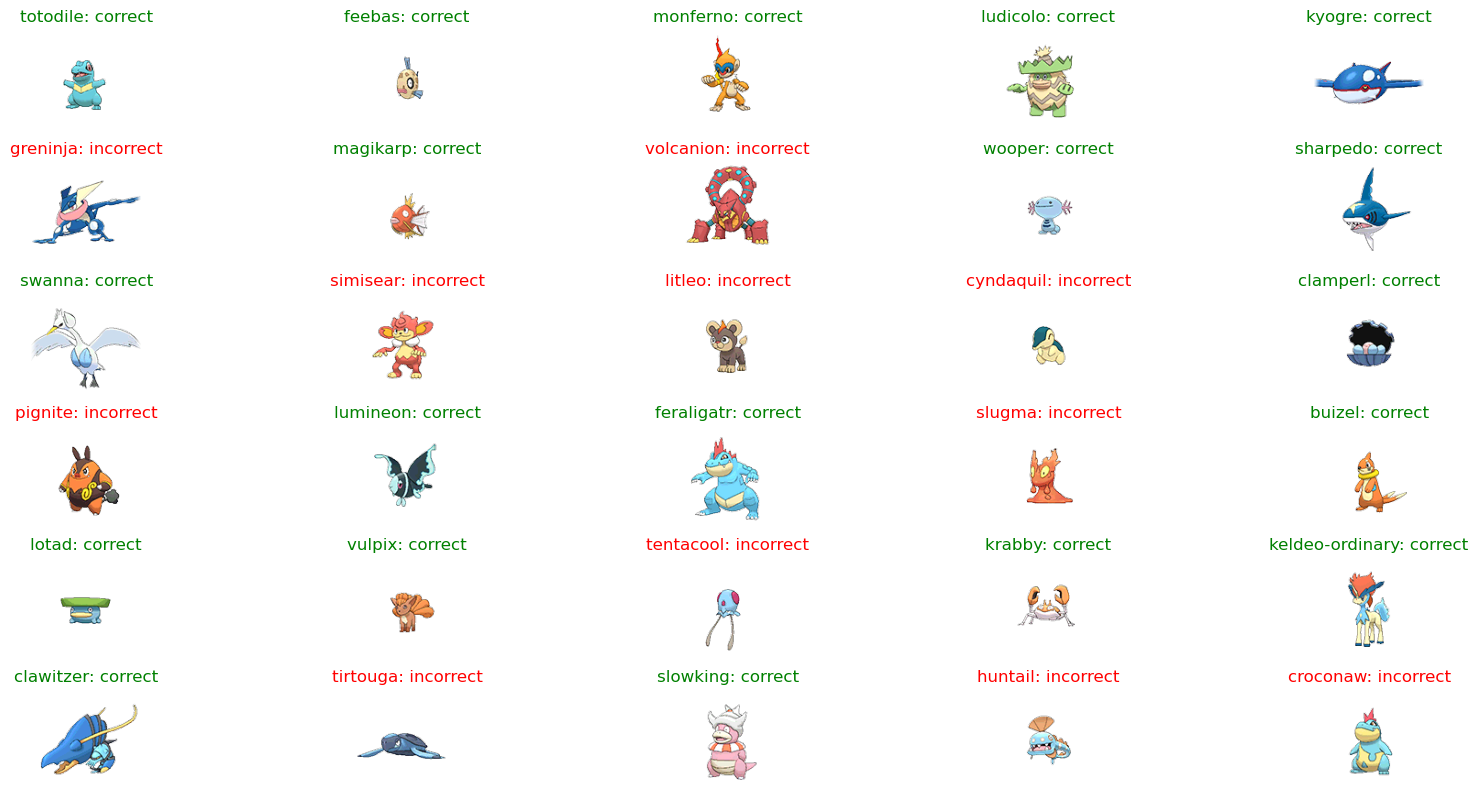

In [19]:
# obtain the images from the filepath at the determined indices
misclassified_imgs = []
names = []
for filepath in misclassified_filepaths:
  misclassified_imgs.append(mpimg.imread(filepath))
  names.append(filepath.split('/')[-1].split('.')[0])

# plot results
f, axarr = plt.subplots(6,5, figsize=(20,10))  
count = 0
for r in range(6):
  for c in range(5):
    axarr[r,c].imshow(misclassified_imgs[count])
    if correctness[count] == 'correct':
      axarr[r,c].set_title(f'{names[count]}: {correctness[count]}', color='green')
    else:
      axarr[r,c].set_title(f'{names[count]}: {correctness[count]}', color='red')
    axarr[r,c].set_axis_off()
    count += 1 
plt.show()
     